In [24]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4').getOrCreate()

In [25]:
yield_df = spark.read.csv("data/yield.csv", header=True, inferSchema=True)
temperature_df = spark.read.csv("data/temp.csv", header=True, inferSchema=True)
rainfall_df = spark.read.csv("data/rainfall.csv", header=True, inferSchema=True)
pesticides_df = spark.read.csv("data/pesticides.csv", header=True, inferSchema=True)

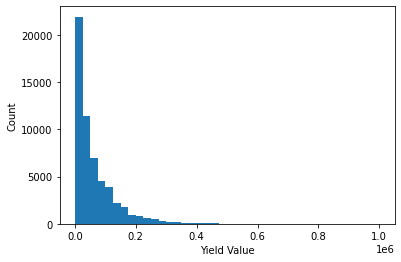

In [26]:
import matplotlib.pyplot as plt
yield_values = yield_df.select("Value").rdd.flatMap(lambda x: x).collect()
plt.hist(yield_values, bins=40)
plt.xlabel('Yield Value')
plt.ylabel('Count')
plt.show()

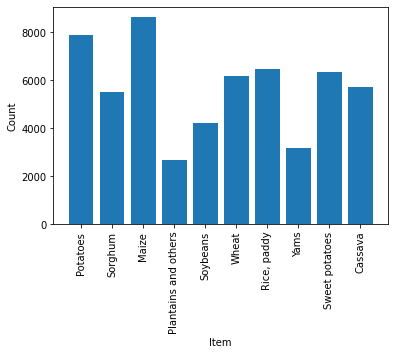

In [4]:
item_values = yield_df.groupBy("Item").count().rdd.flatMap(lambda x: x).collect()
items = [item_values[i] for i in range(0, len(item_values), 2)]
counts = [item_values[i] for i in range(1, len(item_values), 2)]
plt.bar(items, counts)
plt.xlabel('Item')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

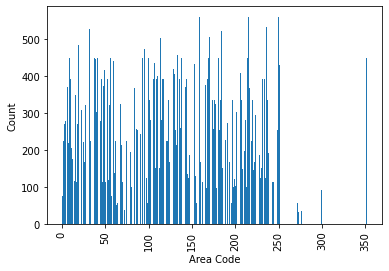

In [5]:
area_code_values = yield_df.groupBy("Area Code").count().rdd.flatMap(lambda x: x).collect()
area_codes = [area_code_values[i] for i in range(0, len(area_code_values), 2)]
counts = [area_code_values[i] for i in range(1, len(area_code_values), 2)]
plt.bar(area_codes, counts)
plt.xlabel('Area Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

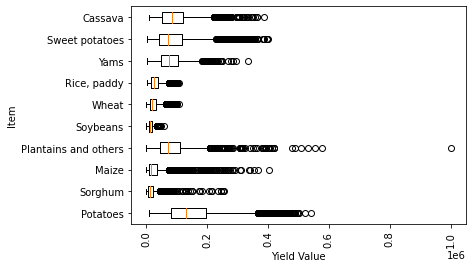

In [6]:
from pyspark.sql import functions as F

# Collect data for box plotting
boxplot_data = yield_df.groupBy("Item").agg(F.collect_list("Value").alias("Values")).collect()
items = [row["Item"] for row in boxplot_data]
values = [row["Values"] for row in boxplot_data]

# Plot
plt.boxplot(values, labels=items, vert=False)
plt.xlabel('Yield Value')
plt.ylabel('Item')
plt.xticks(rotation=90)
plt.show()

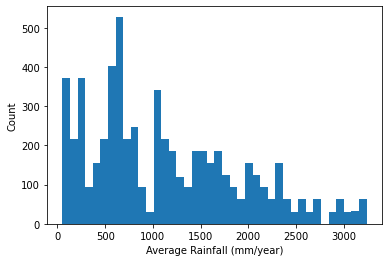

In [7]:
from pyspark.sql.types import FloatType

rainfall_df = rainfall_df.withColumn("average_rain_fall_mm_per_year", rainfall_df["average_rain_fall_mm_per_year"].cast(FloatType()))
rainfall_df = rainfall_df.filter(rainfall_df["average_rain_fall_mm_per_year"].isNotNull())
rainfall_values = rainfall_df.select("average_rain_fall_mm_per_year").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.hist(rainfall_values, bins=40)
plt.xlabel('Average Rainfall (mm/year)')
plt.ylabel('Count')
plt.show()


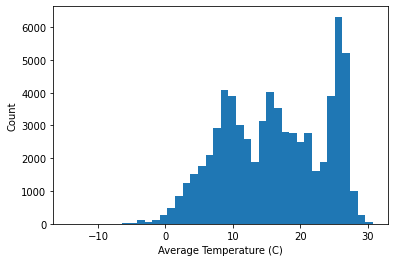

In [9]:
temperature_df = temperature_df.withColumn("avg_temp", temperature_df["avg_temp"].cast(FloatType()))
temperature_df = temperature_df.filter(temperature_df["avg_temp"].isNotNull())
temperature_values = temperature_df.select("avg_temp").rdd.flatMap(lambda x: x).collect()

plt.hist(temperature_values, bins=40)
plt.xlabel('Average Temperature (C)')
plt.ylabel('Count')
plt.show()

+-------+-----------+------+------------------+-----------+------------+-------+------------------+-------+-----------------+-----------------+-----+-----------------+
|summary|Domain Code|Domain|         Area Code|       Area|Element Code|Element|         Item Code|   Item|        Year Code|             Year| Unit|            Value|
+-------+-----------+------+------------------+-----------+------------+-------+------------------+-------+-----------------+-----------------+-----+-----------------+
|  count|      56717| 56717|             56717|      56717|       56717|  56717|             56717|  56717|            56717|            56717|56717|            56717|
|   mean|       null|  null|125.65042227198195|       null|      5419.0|   null|111.61165082779414|   null|1989.669569970203|1989.669569970203| null|62094.66008427808|
| stddev|       null|  null| 75.12019495452651|       null|         0.0|   null|101.27843534146328|   null|16.13319773965858|16.13319773965858| null|67835.93285

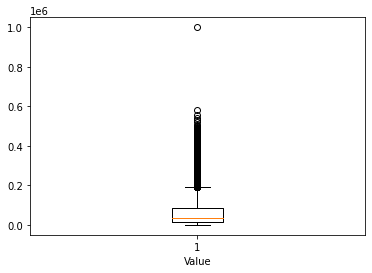

In [10]:
# data quality check
# yeild dataset
# Descriptive statistics
yield_df.describe().show()

# Null value check
yield_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in yield_df.columns]).show()

# Boxplot for Value column
yield_values_for_boxplot = yield_df.select("Value").rdd.flatMap(lambda x: x).collect()
plt.boxplot(yield_values_for_boxplot)
plt.xlabel('Value')
plt.show()

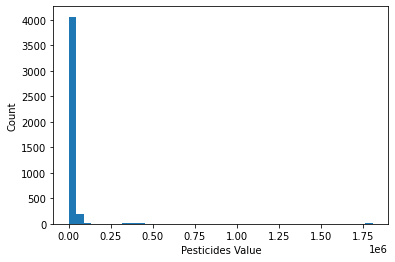

In [11]:
pesticides_values = pesticides_df.select("Value").rdd.flatMap(lambda x: x).collect()

plt.hist(pesticides_values, bins=40)
plt.xlabel('Pesticides Value')
plt.ylabel('Count')
plt.show()

In [12]:
from pyspark.sql.functions import expr

def count_outliers(df, col_name):
    bounds = df.agg(
        F.expr(f'percentile({col_name}, array(0.25))')[0].alias('Q1'),
        F.expr(f'percentile({col_name}, array(0.75))')[0].alias('Q3')
    ).collect()[0]

    IQR = bounds.Q3 - bounds.Q1
    lower_bound = bounds.Q1 - 3.0 * IQR
    upper_bound = bounds.Q3 + 3.0 * IQR

    outliers = df.filter((df[col_name] < lower_bound) | (df[col_name] > upper_bound))
    return outliers.count()


In [13]:
datasets = [yield_df, rainfall_df, pesticides_df, temperature_df]
columns = ["Value", "average_rain_fall_mm_per_year", "Value", "avg_temp"]

for df, col in zip(datasets, columns):
    print(f"Outliers for {col}: ", count_outliers(df, col))
    print("Missing Values for ", col, ":")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Outliers for Value:  777
Missing Values for  Value :
+-----------+------+---------+----+------------+-------+---------+----+---------+----+----+-----+
|Domain Code|Domain|Area Code|Area|Element Code|Element|Item Code|Item|Year Code|Year|Unit|Value|
+-----------+------+---------+----+------------+-------+---------+----+---------+----+----+-----+
|          0|     0|        0|   0|           0|      0|        0|   0|        0|   0|   0|    0|
+-----------+------+---------+----+------------+-------+---------+----+---------+----+----+-----+

Outliers for average_rain_fall_mm_per_year:  0
Missing Values for  average_rain_fall_mm_per_year :
+-----+----+-----------------------------+
| Area|Year|average_rain_fall_mm_per_year|
+-----+----+-----------------------------+
|    0|   0|                            0|
+-----+----+-----------------------------+

Outliers for Value:  428
Missing Values for  Value :
+------+----+-------+----+----+----+-----+
|Domain|Area|Element|Item|Year|Unit|Value|
+-

### Data preparation

In [14]:
yield_df = yield_df.select("Area", "Year", "Value", "Item")
pesticides_df = pesticides_df.select("Area", "Year", "Value")

In [15]:
rainfall_df = rainfall_df.dropna()
temperature_df = temperature_df.dropna()

In [16]:
temperature_df = temperature_df.dropDuplicates(["year", "country"])


In [17]:
from pyspark.sql.functions import log10

pesticides_df = pesticides_df.withColumn("Value_transformed", log10(F.col("Value") + 0.0001))


In [18]:
# Renaming columns for rainfall_df, pesticides_df, and temperature_df
rainfall_df = rainfall_df.withColumnRenamed(" Area", "Area")
pesticides_df = pesticides_df.withColumnRenamed("Value", "Pesticide_tonnes")
pesticides_df = pesticides_df.withColumnRenamed("Value_transformed", "Log_Pesticide_tonnes")
temperature_df = temperature_df.withColumnRenamed("country", "Area")  # Assuming 'country' should be renamed to 'Area'
temperature_df = temperature_df.withColumnRenamed("year", "Year")  # Assuming 'year' should be renamed to 'Year'

# Merging DataFrames
# Assuming you want to merge the dataframes based on common columns like "Area" and "Year"
# The joins are done using inner joins by default. If a different type of join is needed, it can be adjusted.

merged_df = yield_df.join(pesticides_df, ["Area", "Year"], "inner")
merged_df = merged_df.join(rainfall_df, ["Area", "Year"], "inner")
yield_final_df = merged_df.join(temperature_df, ["Area", "Year"], "inner")


In [22]:
merged_df.count()

13130

In [23]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Indexing the 'Area' column
area_indexer = StringIndexer(inputCol="Area", outputCol="AreaIndex")
area_encoder = OneHotEncoder(inputCol="AreaIndex", outputCol="AreaVec")

# Indexing the 'Item' column
item_indexer = StringIndexer(inputCol="Item", outputCol="ItemIndex")
item_encoder = OneHotEncoder(inputCol="ItemIndex", outputCol="ItemVec")

# Constructing the pipeline
pipeline = Pipeline(stages=[area_indexer, item_indexer, area_encoder, item_encoder])

# Applying the transformations
yield_final_df = pipeline.fit(yield_final_df).transform(yield_final_df)

# If you don't want to keep the original 'Area' and 'Item' columns along with their indexed versions:
yield_final_df = yield_final_df.drop("Area", "Item", "AreaIndex", "ItemIndex")


NameError: name 'yield_final_df' is not defined